In [1]:
import numpy as np               # Numpy for mathematical operations
import astropy.io.fits as fits   # Astropy for interpreting FITS files
import os                        # OS for handling large amounts of files
import matplotlib.pyplot as plt  # Matplotlib for figures

%matplotlib inline

In [2]:
import scipy.stats as stats      # SciPy for analysis
from scipy.stats import poisson  # Poisson Distribution
from scipy.stats import norm     # Gaussian Distribution

In [4]:
data_dir = './Lab1Data/'  # Location of FITS files
data_files1 = np.array(sorted(os.listdir(data_dir)))  # List of all files sorted by name
data_files = sorted(data_files1, key=len)  # Files sorted again by length to get numerical order

In [6]:
os.chdir(data_dir)  # Working in location where files are located

In [7]:
fnames = []

for i, val in enumerate(data_files):  # Specifying fits files in folder
    if val.endswith('.fits'):
        fnames.append(val)
        
fnames = np.array(fnames)     # Converting to Numpy array 

## Images:

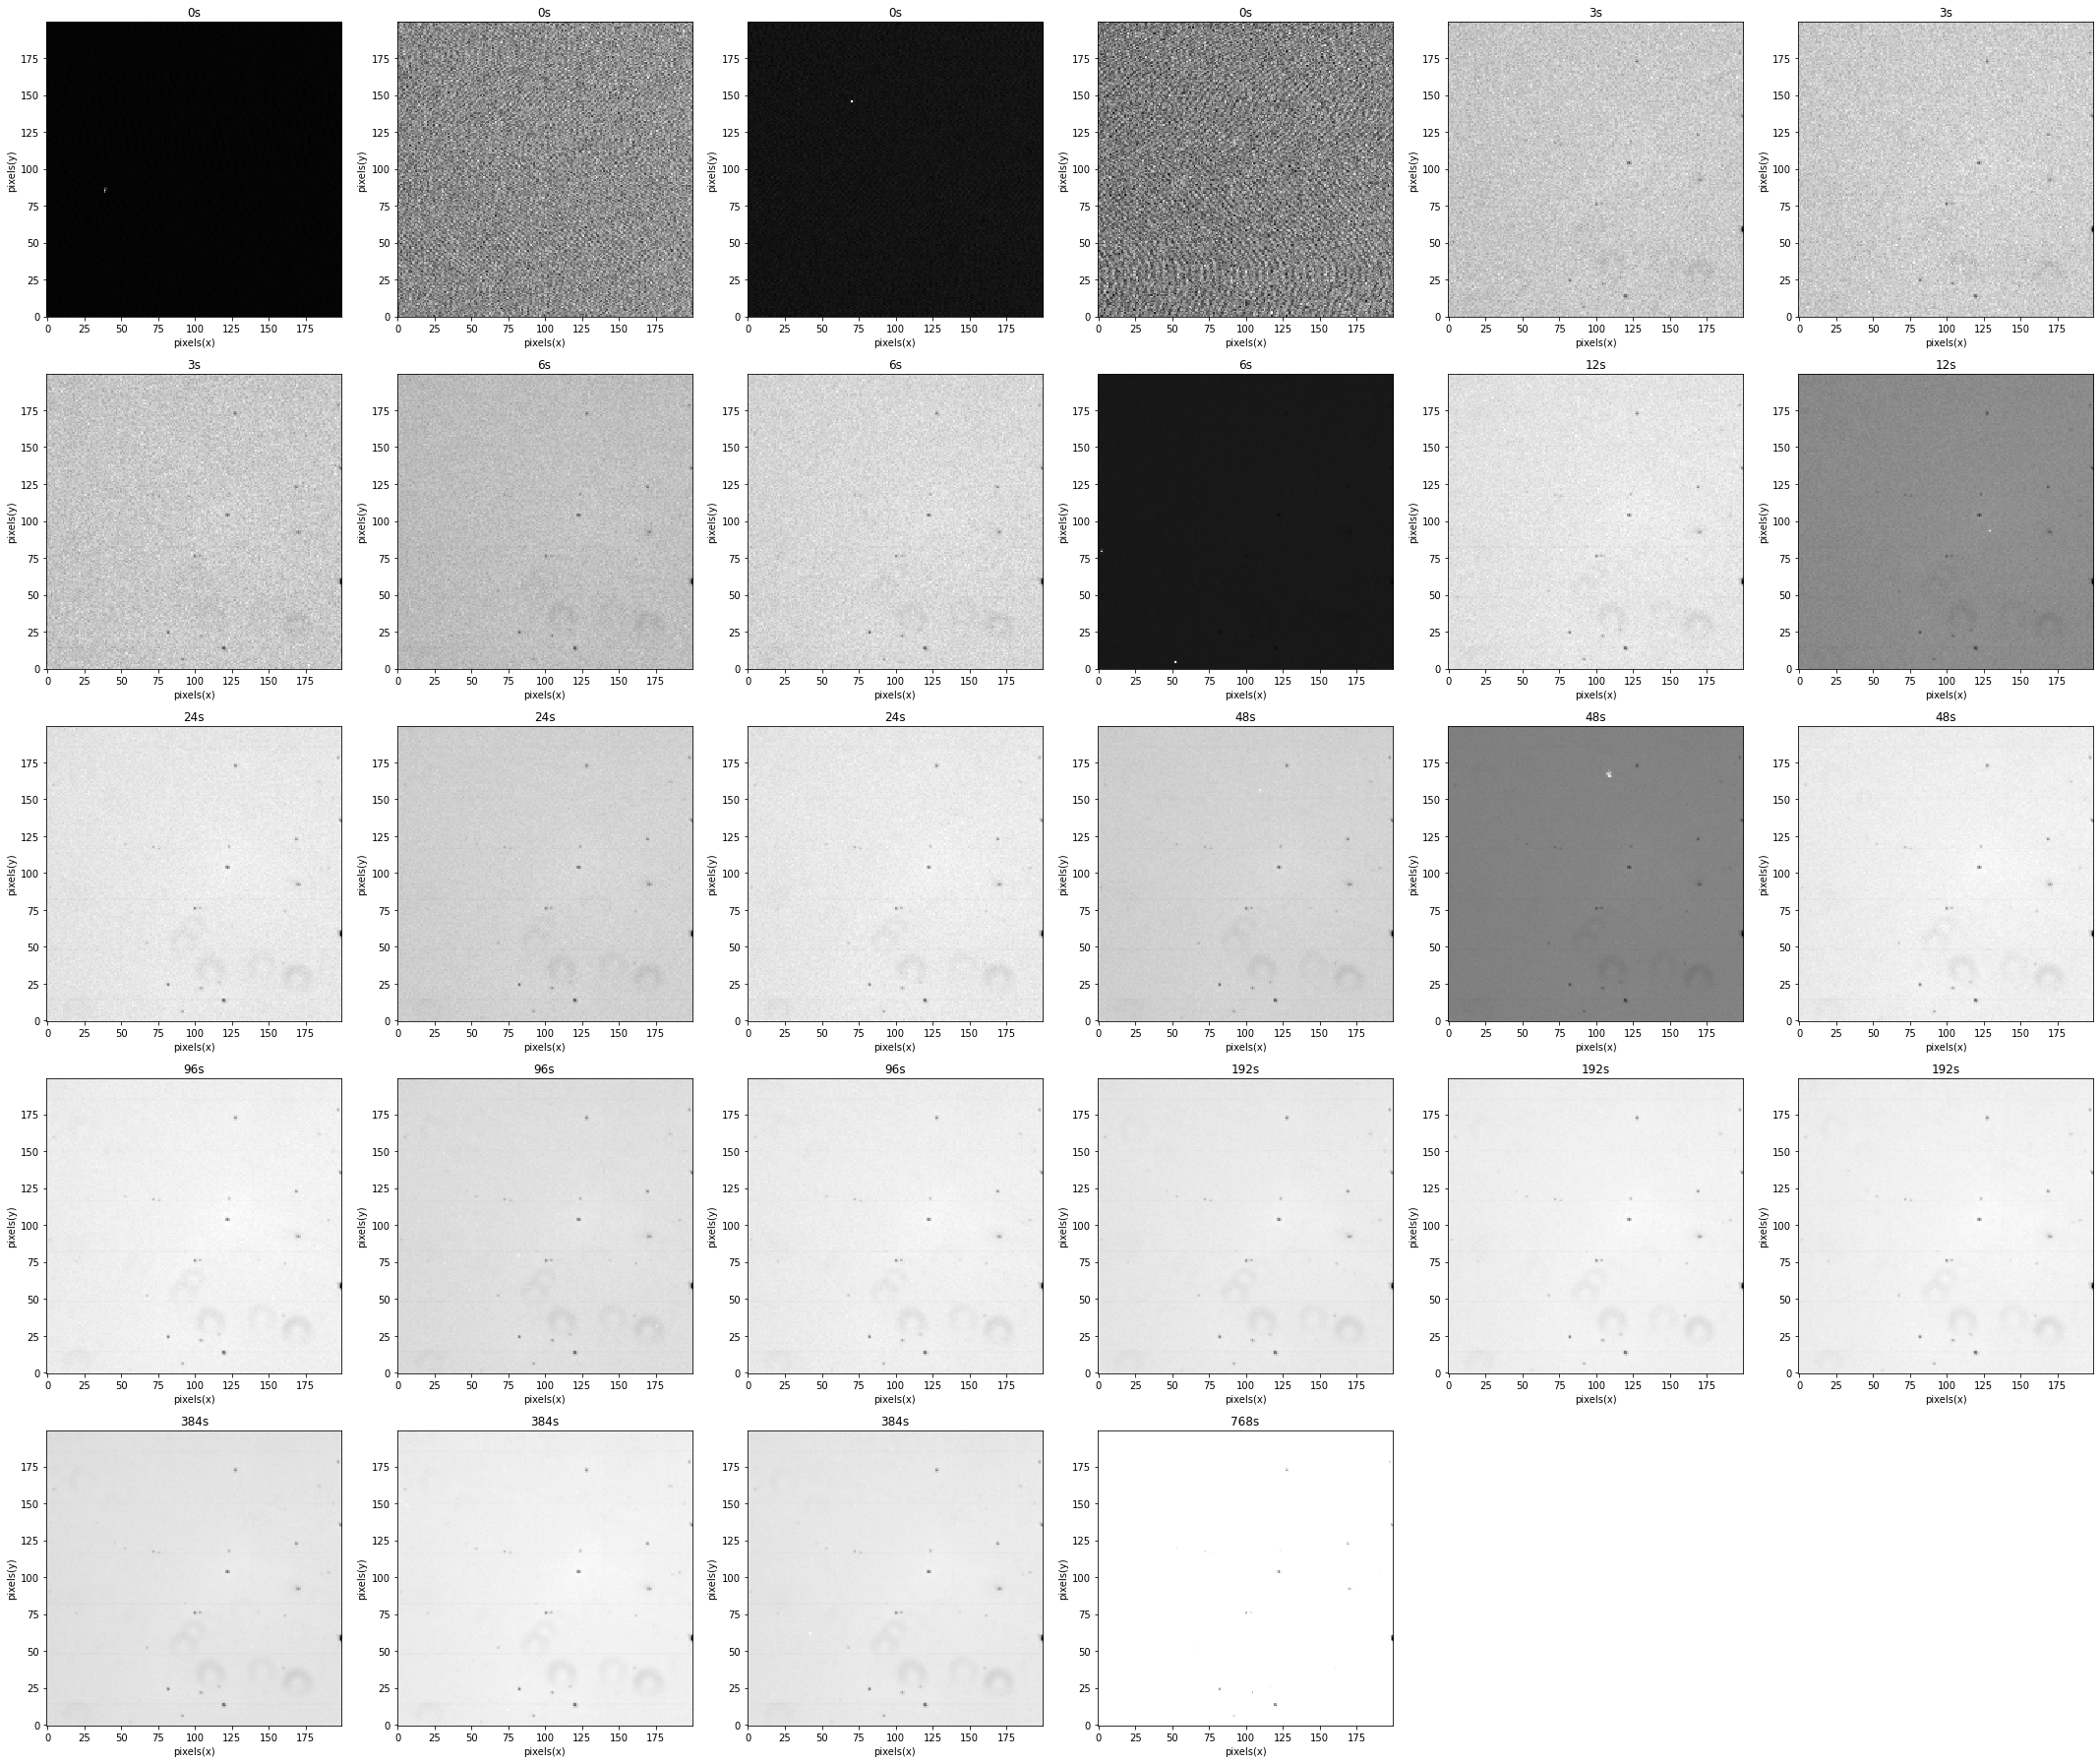

In [9]:
total_data=[]
exp_time=[]
rows = 5
columns = 6
plt.figure(figsize=(30,25))

for i, val in enumerate(fnames):
    plt.subplot(rows, columns, i+1)
    data = fits.getdata(val)[400:600,400:600]  # Narrowing data to region without overscan
    total_data.append(data)                    # Creating array with data for each FITS file
    plt.imshow(data,origin='lower',interpolation='nearest',cmap='gray')
    plt.xlabel('pixels(x)')                    # Plotting iages of clean data region
    plt.ylabel('pixels(y)')
    plt.tight_layout()
    hdr = fits.open(fnames[i])
    et = hdr[0].header['EXPTIME']              # Accessing ASCII information about exposure time
    plt.title(str(et)+'s')
    exp_time.append(et)                        # Creating array of exposure times for each image

In [12]:
# Inspecting maximum of last data frame, which appear to be over saturated

print('Max of d28.fits:', np.max(fits.getdata('d28.fits')[400:600,400:600]), 'ADU')

Max of d28.fits: 65535 ADU


In [14]:
fnames = fnames[0:-1]          # Removing the last data file due to over saturation
total_data = total_data[0:-1]
exp_time = exp_time[0:-1]      # Doing the same for exposure time array

In [15]:
print(exp_time)  # Checking how many of the files are bias frames (0 time)

[0, 0, 0, 0, 3, 3, 3, 6, 6, 6, 12, 12, 24, 24, 24, 48, 48, 48, 96, 96, 96, 192, 192, 192, 384, 384, 384]


In [16]:
bias_total_data = total_data[0:4]   # Splitting total data array into bias and flat frames
flat_total_data = total_data[4:27]
flat_exp_time = exp_time[4:27]      # Splitting exposure times to non-zero values only
flat_names = fnames[4:27]           # Defining names of flat files

In [17]:
def my_mean(arr):         # Function for mean
    total = 0
    count = 0
    for i in arr:
        total += i        # Sum over values in array
        count += 1        # Total count of values
    return total / count

$$ \bar{x} = \frac{1}{N} \sum_{i=1}^{N}{x_i} $$

In [18]:
def my_std(arr):                     # Function for standard deviation
    total = 0
    count = 0
    val = 0
    for i in arr:
        total += i                   # Sum over values in array
        count += 1                   # Total count of data points
        val += (i-(total/count))**2  # Sum of (value - mean)^2
    return (val/count)**0.5

In [19]:
flat_data = [f - b for f, b in zip(flat_total_data, my_mean(bias_total_data))]
# Bias subtracting from flat data using mean of bias frames

$$\sigma_x = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i-\bar{x})^2}$$

$$\sigma_x^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i-\bar{x})^2$$

In [20]:
means_list = []
std_list = []
var_list = []
x_list = []

for data in flat_data:
    x = data.flatten()                  # Flattening each data set to 1 dimension
    x_list.append(x)
    mean = my_mean(x)                   # Calculating mean with previously defined function
    means_list.append(mean)             # Creating array of all calculated means
    std = my_std(x)                     # Calculating standard deviation with previously defined function
    std_list.append(std)                # Creating array of all calculated standard deviations
    var = std**2                        # Calculating variance by squaring standard deviation
    var_list.append(var)                # Creating an array of all calulated variances

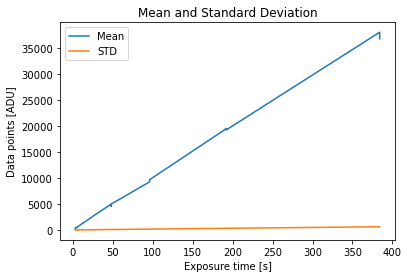

In [21]:
plt.plot(flat_exp_time, means_list, label='Mean')  # Mean vs. exposure time plot
plt.plot(flat_exp_time, std_list, label='STD')     # Standard deviation vs. exposure time plot

plt.title('Mean and Standard Deviation')
plt.xlabel('Exposure time [s]')
plt.ylabel('Data points [ADU]')
plt.legend()

Text(0.5, 1.0, '3 Second Exposure')

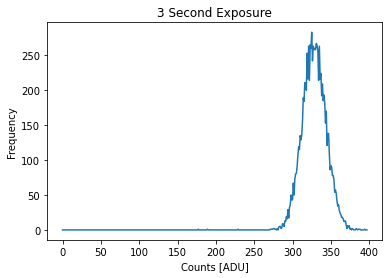

In [22]:
count_min = 0
count_max_3 = x_list[0].max()
count_range_3 = np.arange(count_min, count_max_3+1)
hist_list_3 = []

for i in count_range_3:  # Creating Histogram for 3 second exposure
    count_freq = len(np.where(x_list[0]==i)[0])
    hist_list_3.append(count_freq)

m3 = my_mean(hist_list_3)
v3 = (my_std(hist_list_3))**2
plt.plot(count_range_3, hist_list_3, label = 'Histogram')
plt.xlabel('Counts [ADU]')
plt.ylabel('Frequency')
plt.title('3 Second Exposure')

Text(0.5, 1.0, '384 Second Exposure')

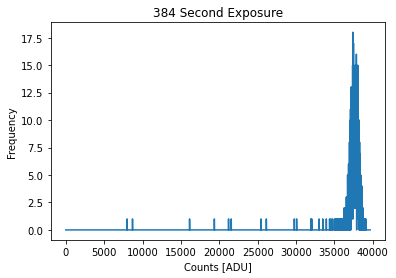

In [23]:
count_min = 0
count_max_384 = x_list[21].max()
count_range_384 = np.arange(count_min, count_max_384+1)
hist_list_384 = []

for i in count_range_384:  # Creating Histogram for 384 second exposure
    count_freq = len(np.where(x_list[21]==i)[0])
    hist_list_384.append(count_freq)
    
m384 = my_mean(hist_list_384)
v384 = (my_std(hist_list_384))**2
plt.plot(count_range_384, hist_list_384, label = 'Histogram')
plt.xlabel('Counts [ADU]')
plt.ylabel('Frequency')
plt.title('384 Second Exposure')

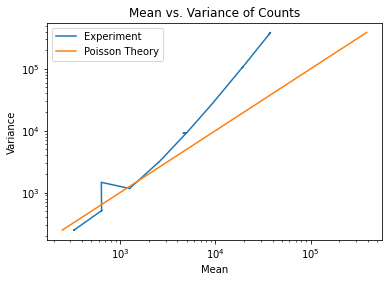

In [24]:
plt.plot(means_list, var_list, label='Experiment')  # Plot of means vs. variances for each flat dome data set
lims = [np.min([means_list, var_list]), np.max([means_list, var_list])]
plt.plot(lims, lims, label='Poisson Theory')        # y = x line for equal mean and variance (Poisson)

plt.title('Mean vs. Variance of Counts')
plt.xlabel('Mean')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [25]:
mom_list = []
sdom_list = []

def mom_sdom(files):                   # Function for mean of means and standard devition of the means
    flat_zip = zip(files, flat_exp_time)
    for i, j in flat_zip:
        data = fits.getdata(i)[400:600, 400:600]
        x = data.flatten()
        x = x / j                      # Conversion from ADU to ADU / s
        mom_list.append(my_mean(x))
        sdom_list.append(my_std(x))
    mom = my_mean(mom_list)
    sdom = np.sqrt(np.sum(np.array(sdom_list)**2)/len(sdom_list)**2)
    return [mom, sdom]


three_frame = mom_sdom(flat_names[0:3])  # Values for a variety of frames
six_frame = mom_sdom(flat_names[0:6])
ten_frame = mom_sdom(flat_names[0:10])
twenty_frame = mom_sdom(flat_names[0:20])
thirty_frame = mom_sdom(flat_names[0:30])

$$ \bar{x} = \frac{1}{N} \sum_{i=1}^{N} \bar{x_i} $$

$$ \sigma_{\bar{x}} = \frac{1}{N} \sqrt{\sum_{i=1}^{N} \sigma_i^2} $$

Text(0, 0.5, 'Mean of Means [ADU/s]')

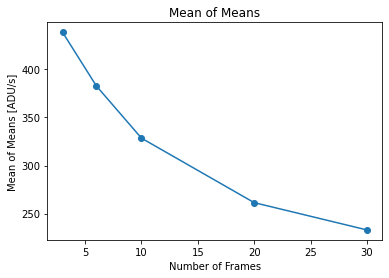

In [26]:
n_frames = [3, 6, 10, 20, 30]      # Defining number of frames used
mom_vals = [three_frame[0], six_frame[0], ten_frame[0], twenty_frame[0], thirty_frame[0]]

plt.plot(n_frames, mom_vals, 'o-')  # Plotting number of frames vs. mean of means

plt.title('Mean of Means')
plt.xlabel('Number of Frames')
plt.ylabel('Mean of Means [ADU/s]')

Text(0, 0.5, 'Standard Deviation of Means[ADU/s]')

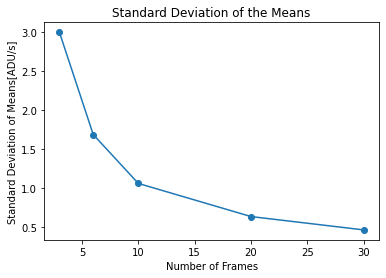

In [27]:
sdom_vals = [three_frame[1], six_frame[1], ten_frame[1], twenty_frame[1], thirty_frame[1]]

plt.plot(n_frames, sdom_vals, 'o-')  # Plotting number of frames vs. SDOM

plt.title('Standard Deviation of the Means')
plt.xlabel('Number of Frames')
plt.ylabel('Standard Deviation of Means[ADU/s]')

In [28]:
def P(x, m):                                              # Function for Poisson Distribution
    stir = np.sqrt(2 * np.pi * x) * (x / np.exp(1)) ** x  # Stirling's approximation for factorial
    return (m**x * np.exp(-m))/(stir)

$$ P(x; \mu) = \frac{\mu^x}{x!}e^{-\mu} \approx \frac{\mu^x}{\sqrt{2 \pi x}}(\frac{x}{e})^{-x}e^{-\mu} $$

$$ P(x; \mu, \sigma) = \frac{1}{\sigma \sqrt{2 \pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2} $$

In [29]:
def G(x, m, s):  # Function for Gaussian Distribution
    return (s*np.sqrt(2*np.pi))**-1 * np.exp(-(1/2)*((x-m)/s)**2)

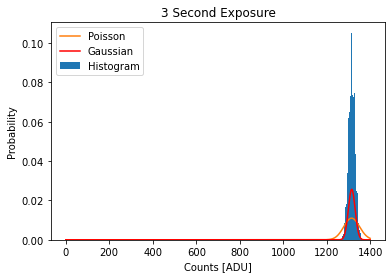

In [46]:
short = fits.getdata('d5.fits')[400:600,400:600].flatten()  # SciPy plot for histogram
weights = np.ones_like(short)/float(len(short))  # Normalization
plt.hist(short, label='Histogram', weights=weights, bins=100)

x = np.arange(0,1400,1)  # SciPy plot for Poisson Distribution
y = poisson.pmf(x, my_mean(short))
plt.plot(x, y, label='Poisson')

gauss = norm.pdf(x, my_mean(short), my_std(short),)  # SciPy plot for Gaussian Distribution
plt.plot(x, gauss, 'r',label='Gaussian')

plt.xlabel('Counts [ADU]')
plt.ylabel('Probability')
plt.title('3 Second Exposure')
plt.legend()

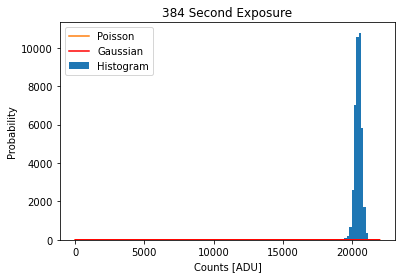

In [47]:
short = fits.getdata('d22.fits')[400:600,400:600].flatten()  # SciPy plot for histogram
weights = np.ones_like(short)/float(len(short))  # Normalization
plt.hist(short, label='Histogram', bins=100)

x = np.arange(0,22000,1)  # SciPy plot for Poisson
y = poisson.pmf(x, my_mean(short))
plt.plot(x, y, label='Poisson')

gauss = norm.pdf(x, my_mean(short), my_std(short))  # SciPy plot for Gaussian
plt.plot(x, gauss, 'r',label='Gaussian')

plt.xlabel('Counts [ADU]')
plt.ylabel('Probability')
plt.title('384 Second Exposure')
plt.legend()

Text(4.75, 0.5, 'Variance [ADU^2]')

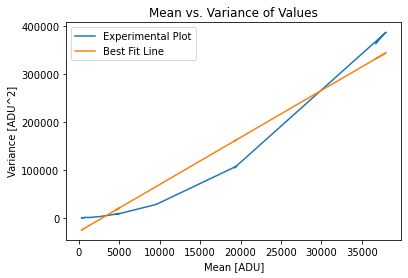

In [48]:
x = [int(j) for j in means_list]
y = var_list
plt.plot(x, y, label='Experimental Plot')  # Plot of means vs. variances for each flat dome data set
m, b = np.polyfit(x, y, 1)
plt.plot(x, [m*i for i in x] + b, label='Best Fit Line') # Plot of best fit
Gain = m ** -1 # Final value for gain

plt.draw()
plt.legend()
plt.title('Mean vs. Variance of Values')
plt.xlabel('Mean [ADU]')
plt.ylabel('Variance [ADU^2]')

(-1500.0, 1500.0)

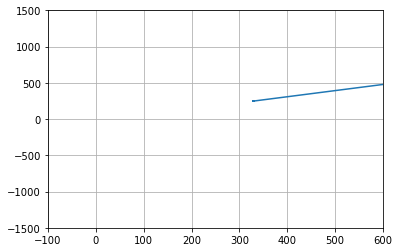

In [49]:
x = [int(j) for j in means_list]  # Zoomed in plot to estimate read noise
y = var_list
plt.plot(x, y, label='Experimental Plot')

plt.draw()
plt.grid()
plt.xlim(-100, 600)
plt.ylim(-1500, 1500)

In [50]:
print('Gain =', m**-1, '[e- / ADU]') 

# Final result for gain

Gain = 0.10186051884891204 [e- / ADU]
